# Le problème : la prévision de consommation électrique

Pour garantir l'équilibre offre-demande à chaque instant et gérer l'acheminement de l'électricité, RTE construit ses propres prévisions de la consommation nationale, régionale, et locale, à différentes échéances de temps (de l'infrajournalier au pluri-annuel).

Ici on se focalise sur un problème particulier : **la prévision de la consommation électrique nationale horaire à horizon J+1** (on suppose qu'on connaît toutes les données jusqu'au jour J inclus). 

## Les données : Eco2mix

La courbe de charge France est disponible sur eco2mix :
http://www.rte-france.com/fr/eco2mix/eco2mix
ou sur application mobile.

Vous pouvez naviguer sur le site pour vous familiariser avec les données sur lesquelles vous allez travailler.

## Objectif :

Au cours de ce TP, nous allons aborder les différentes étapes nécessaires à la construction d'un modèle de prévision de consommation :

1) Formalisation du problème Y = f(X): que souhaite-t-on prédire (quel est mon Y) ? Avec quelles variables explicatives (quel est mon X) ?

2) Collecte des données: où se trouvent les données ? Quel est le format ? Comment les récupérer ? (FACULTATIF - voir TP "TP1_Preparation_donnees")

3) Import des données et analyses descriptives : visualiser des séries temporelles, statistiques descriptives

4) Transformation des données (feature engineering) pour entrainer et tester un premier modèle

5) Création de prévision à dire d'expert pour servir de référence.

6) Découpage des données : apprentissage - test

7) Evaluer un modèle

8) Tester des algorithmes de référence : régression linéaire, forêts aléatoires, xgboost

9) Itérer à partir des modèles testés pour améliorer les prévisions

Nous verrons qu'une difficulté majeure réside dans la construction des "bonnes" variables explicatives ("garbage in, garbage out").

**Le notebook est parsemé de questions (<font color='green'>en vert</font>). Vous pouvez y répondre sur la feuille fournie.**

## Méthodes de prévision considérées

Les modèles actuels reposent sur des méthodes de régression linéaire et non-linéaire. Nous étudierons ici les limites de la régression linéaire.

Pour améliorer les prévisions, nous aurons recours aux méthodes dites de Machine Learning. Ces méthodes ne dépendent pas d'une formalisation a priori du lien entre les variables explicatives X et la variable à expliquer Y. 
Elles sont souvent moins interprétables mais peuvent être plus efficaces en prévision. Elles peuvent nécessiter plus de temps de calcul et plus de données pour cela.

Construire un bon modèle d'apprentissage nécessite en général de la connaissance experte dans le domaine d'intérêt pour créer des modèles pertinents et efficaces. 

## To be continued : deep learning

Le deuxième TP permettra d'investiguer les modèles "Deep" avec réseaux de neurones, en montrant le moindre besoin en feature engineering et leur plus grande capacité à absorber l'information grâce aux représentations hiérarchiques qu'ils créent.

# Environnement de travail 

Ceci est un notebook jupyter. Il permet d'exécuter du code python, d'afficher des résultats et d'écrire du texte pour décrire l'ensemble de l'étude.

<font color='red'>
    
**NB : L'aide de python est accessible en tapant help(nom_de_la_commande)**

</font>

## Chargement des packages

In [3]:
# Exécutez la cellule ci-dessous (par exemple avec shift-entrée)
# Si vous exécuter ce notebook depuis votre PC, il faudra peut-etre installer certaines librairies avec 
# 'pip install ma_librairie'
import os  # accès aux commandes système

import datetime  # structure de données pour gérer des objets calendaires
from datetime import timezone
import pandas as pd  # gérer des tables de données en python
import numpy as np  # librairie d'opérations mathématiques
from math import sqrt

import pytz

import sklearn  # librairie de machine learning
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot, iplot_mpl
import matplotlib.pyplot as plt  # tracer des visualisations
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import zipfile  # compresser ou décompresser fichier

%matplotlib inline

%autosave 0

Autosave disabled


## Données disponibles

Choix du répertoire de travail "data_folder" dans lequel tous les fichiers csv seront entreposés. Ici le répertoire s'appelle *data*.

Ensuite on affiche les fichiers du répertoire pour vérification

In [4]:
data_folder = os.path.join(os.getcwd(), "data")

In [5]:
print("Mon repertoire est : {}".format(data_folder))
print("Fichiers contenus dans ce répertoire :")
for file in os.listdir(data_folder):
    print(" - " + file)

Mon repertoire est : /home/marotant/dev/TP_Formation_Conso_MachineLearning/data
Fichiers contenus dans ce répertoire :
 - Xinput.zip
 - joursFeries.csv
 - Yconso.csv
 - StationsMeteoRTE.csv
 - YconsoT0.csv
 - Yconso_2014_2018.csv
 - eCO2mix_RTE_tempo_2017-2018.xls
 - Xtemperature.zip
 - meteoX_T0_T24.zip
 - X2input.zip
 - communes_coordonnees.csv


# Récupération des données dans Python

Dans cette partie nous allons charger les fichiers csv nécessaires pour l'analyse, puis les convertir en data-frame python : 
- Yconso.csv
- Xinput.csv

Rappel : Les données brutes ont été pré-traitées à l'aide du notebook *TP1_Preparation_donnees.ipynb* pour obtenir ces deux fichiers.

## import de Yconso.csv

In [6]:
Yconso_csv = os.path.join(data_folder, "Yconso.csv")
Yconso = pd.read_csv(Yconso_csv)
display(Yconso.head(5)) # affichage des premières lignes
display(Yconso.info()) # affichage du type de données et de la taille de chaque colonne
#print(Yconso.dtypes) 
Yconso['ds'].max

,ds,y
0,2014-01-08 00:00:00+00:00,62008
1,2014-01-08 01:00:00+00:00,57298
2,2014-01-08 02:00:00+00:00,56216
3,2014-01-08 03:00:00+00:00,53719
4,2014-01-08 04:00:00+00:00,51798


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43368 entries, 0 to 43367
Data columns (total 2 columns):
ds    43368 non-null object
y     43368 non-null int64
dtypes: int64(1), object(1)
memory usage: 677.8+ KB


None

<bound method Series.max of 0        2014-01-08 00:00:00+00:00
1        2014-01-08 01:00:00+00:00
2        2014-01-08 02:00:00+00:00
3        2014-01-08 03:00:00+00:00
4        2014-01-08 04:00:00+00:00
                   ...            
43363    2018-12-19 19:00:00+00:00
43364    2018-12-19 20:00:00+00:00
43365    2018-12-19 21:00:00+00:00
43366    2018-12-19 22:00:00+00:00
43367    2018-12-19 23:00:00+00:00
Name: ds, Length: 43368, dtype: object>

La colonne "ds" contient la date, mais celle-ci n'est pas reconnue en tant que telle mais en tant que chaîne de caractères (https://pbpython.com/pandas_dtypes.html). On va la convertir en objet de type "datetime" plus approprié pour extraire des informations comme le jour de la semaine ou l'heure.  
Pour plus d'information, voir le TP1_Preparation_donnees.

In [7]:
Yconso['ds'] = pd.to_datetime(Yconso['ds'],utc=True)
print(Yconso.dtypes)
display(Yconso.head(5))

display(Yconso.tail(5))

ds    datetime64[ns, UTC]
y                   int64
dtype: object


,ds,y
0,2014-01-08 00:00:00+00:00,62008
1,2014-01-08 01:00:00+00:00,57298
2,2014-01-08 02:00:00+00:00,56216
3,2014-01-08 03:00:00+00:00,53719
4,2014-01-08 04:00:00+00:00,51798


,ds,y
43363,2018-12-19 19:00:00+00:00,75670
43364,2018-12-19 20:00:00+00:00,73068
43365,2018-12-19 21:00:00+00:00,68589
43366,2018-12-19 22:00:00+00:00,65288
43367,2018-12-19 23:00:00+00:00,67766


Visuellemement cela ne change rien.

On peut aussi afficher la dimension du DataFrame (toujours s'assurer que cela correspond aux valeurs attendues) : 

In [8]:
print(Yconso.shape)

(43368, 2)


## Import des variables d'entrée du modèle prédictif 

**Attention : Les données présentes dans Xinput sont encryptées dans un fichier zip.**  
Pour les lire vous avez besoin d'un mot de passe qui ne peut vous être donné que dans le cadre d'un travail au sein de RTE.

Sinon, la lecture se déroule comme pour le fichier Yconso.csv : transformation en datetime de la colonne *ds* et vérification des dimensions.

In [14]:
password = ''

In [15]:
Xinput_zip = os.path.join(data_folder, "X2input.zip")
# Pour travailler avec les fichiers zip, on utilise la bibliothèque **zipfile**.
zipfile_xinput = zipfile.ZipFile(Xinput_zip)
zipfile_xinput.setpassword(bytes(password,'utf-8'))
Xinput = pd.read_csv(zipfile_xinput.open('X2input.csv'),sep=",",engine='c',header=0)

Xinput['ds'] = pd.to_datetime(Xinput['ds'],utc=True)



Vous disposez de relevés de températures en stations (voir le fichier *data/StationsMeteoRTE.csv* pour plus d'informations) ainsi que d'une température France prévue pour l'instant considéré et celle réalisée la veille.

In [16]:
print("Dimensions de X")
print(Xinput.shape)
print("")
print("Colonnes de X")
print(Xinput.columns)
print("")
print("Aperçu de X")
display(Xinput.head(35))


Dimensions de X
(43368, 81)

Colonnes de X
Index(['ds', 'holiday', '002_0', '002_24', '005_0', '005_24', '015_0',
       '015_24', '027_0', '027_24', '070_0', '070_24', '110_0', '110_24',
       '120_0', '120_24', '130_0', '130_24', '145_0', '145_24', '149_0',
       '149_24', '156_0', '156_24', '168_0', '168_24', '180_0', '180_24',
       '190_0', '190_24', '222_0', '222_24', '240_0', '240_24', '255_0',
       '255_24', '260_0', '260_24', '280_0', '280_24', '299_0', '299_24',
       '434_0', '434_24', '460_0', '460_24', '481_0', '481_24', '497_0',
       '497_24', '510_0', '510_24', '579_0', '579_24', '588_0', '588_24',
       '621_0', '621_24', '630_0', '630_24', '643_0', '643_24', '645_0',
       '645_24', '650_0', '650_24', '675_0', '675_24', '690_0', '690_24',
       '747_0', '747_24', 'Th_real_24h_avant', 'Th_prev', 'month', 'hour',
       'weekday', 'lag1H', 'lag1D', 'lag1W', 'posan'],
      dtype='object')

Aperçu de X


,ds,holiday,002_0,002_24,005_0,005_24,015_0,015_24,027_0,027_24,...,747_24,Th_real_24h_avant,Th_prev,month,hour,weekday,lag1H,lag1D,lag1W,posan
0,2014-01-08 00:00:00+00:00,NaN,10.30,9.69,10.00,9.80,9.69,9.30,10.19,10.50,...,11.20,9.846930,9.911160,1,0,2,NaN,NaN,NaN,8
1,2014-01-08 01:00:00+00:00,NaN,10.10,9.40,9.69,9.80,9.40,9.30,10.30,10.30,...,11.10,9.848500,9.790830,1,1,2,62008.0,NaN,NaN,8
2,2014-01-08 02:00:00+00:00,NaN,10.00,9.19,9.90,9.60,9.19,9.40,10.30,10.00,...,11.00,9.681580,9.634990,1,2,2,57298.0,NaN,NaN,8
3,2014-01-08 03:00:00+00:00,NaN,9.90,9.00,9.50,9.19,9.19,9.19,10.19,9.80,...,10.90,9.487130,9.445360,1,3,2,56216.0,NaN,NaN,8
4,2014-01-08 04:00:00+00:00,NaN,9.90,8.80,9.00,8.90,8.90,9.00,10.19,9.60,...,10.80,9.490410,9.241585,1,4,2,53719.0,NaN,NaN,8
5,2014-01-08 05:00:00+00:00,NaN,9.69,9.40,9.40,9.10,9.30,9.40,10.10,9.50,...,9.19,9.346880,9.045105,1,5,2,51798.0,NaN,NaN,8
6,2014-01-08 06:00:00+00:00,NaN,9.60,9.19,9.60,8.90,9.19,9.10,10.30,9.50,...,9.00,9.284855,8.915265,1,6,2,52083.0,NaN,NaN,8
7,2014-01-08 07:00:00+00:00,NaN,9.60,9.50,9.50,8.60,9.19,9.50,10.50,9.60,...,9.50,9.377060,8.964100,1,7,2,56082.0,NaN,NaN,8
8,2014-01-08 08:00:00+00:00,NaN,9.90,9.40,9.19,8.60,9.30,9.50,10.70,9.50,...,9.90,9.543030,9.106500,1,8,2,63083.0,NaN,NaN,8
9,2014-01-08 09:00:00+00:00,NaN,10.00,9.40,10.00,9.10,9.69,9.80,10.80,9.60,...,10.70,10.109460,9.630050,1,9,2,68358.0,NaN,NaN,8


Dans cette étude de cas, par soucis de simplicité, nous allons travailler uniquement avec des
**températures France**. Utiliser les températures des différentes stations météo serait une piste
intéressante pour améliorer le modèle.

In [13]:
Xinput = Xinput[['ds', 'month', 'hour', 'posan', 'weekday', 'holiday', 'Th_real_24h_avant', 'Th_prev', 'lag1D', 'lag1W']]

<font color='green'>
    
* Quelles sont les variables disponibles (dans Xinput et Yconso)?
    
* Quelles sont les dimensions (nombre d’observations et de variables) de Xinput et Yconso après lecture des fichiers csv? Est-ce cohérent?

* Les données présentes dans Xinput vous semblent-elles pertinentes pour prédire la consommation nationale présente dans Yconso ?

* Que pensez-vous de cette notion de "Température France"?
</font>

# Visualisation des données 

La DataScience et le Machine Learning supposent de bien appréhender les données sur lesquelles nos modèles vont être entrainés. Pour cela, il est utile de faire des statistiques descriptives et des visualisations de nos différentes variables.

Traitant d'un problème de prévision, on visualisera en particulier des séries temporelles.

Dans les slides d'introduction, vous allez voir des :
- échantillons de données
- profils de courbe de consommation journaliers et saisonniers
- visualisations de corrélation entre conso J et conso retardée


# Outils de construction de modèle
<img src="pictures/etabli.jpg"  width=500 height=60>

## Construction des jeux d'entrainement et de test

Pour éviter de construire un modèle qui apprend "par coeur" sur ses données, et qui disposerait alors d'une capacité de généralisation faible, il est d'usage courant de disposer de plusieurs jeux de données (de caractéristiques similaires). Le minimum est de construire 

* un jeu d'entraînement, sur lequel on estime le modèle, 

* un jeu de test, jamais vu durant l'entraînement, sur lequel on va évaluer le modèle. 

Rapidement dit : un bon modèle est un modèle dont la capacité prédictive ne se dégrade pas trop sur le jeu test.

Pour cela, on crée la fonction *prepareDataSetEntrainementTest* qui va permettre de couper Y et Xinput en deux parties.

In [14]:
def prepareDataSetEntrainementTest(Xinput, Yconso, dateDebut, dateRupture, nbJourlagRegresseur=0):
    
    dateStart = Xinput.iloc[0]['ds']
    
    DateStartWithLag = dateStart + pd.Timedelta(str(nbJourlagRegresseur)+' days')  #si un a un regresseur avec du lag, il faut prendre en compte ce lag et commencer l'entrainement a la date de debut des donnees+ce lag
    XinputTest = Xinput[(Xinput.ds >= dateRupture)]    

    XinputTrain=Xinput[(Xinput.ds < dateRupture) & (Xinput.ds > DateStartWithLag) & (Xinput.ds > dateDebut)]
    YconsoTrain=Yconso[(Yconso.ds < dateRupture) & (Yconso.ds > DateStartWithLag) & (Yconso.ds > dateDebut)]
    YconsoTest=Yconso[(Xinput.ds >= dateRupture)]
    
    return XinputTrain, XinputTest, YconsoTrain, YconsoTest

## Fonctions utilitaires

Créons la fonction modelError qui va calculer pour un échantillon (Y, Y_hat) différents scores :
- erreur relative moyenne (MAPE en %)
- erreur relative max (en %)
- RMSE (en MW)

Cette fonction est ensuite utilisée par les fonctions *evaluation* et *evaluation_par* qui nous permettront d'évaluer nos modèles.

<img src="pictures/evaluation.jpg"  width=250 height=30>

In [43]:
def modelError(Y_true, Yhat):

    Y = Y_true.reset_index(drop=True).copy()
    
    relativeErrorsTest = np.abs((Y['y'] - Yhat) /Y['y']) 
    errorMean = np.mean(relativeErrorsTest)
    errorMax = np.max(relativeErrorsTest)
    rmse = np.sqrt(mean_squared_error(Y['y'], Yhat))
   
    return relativeErrorsTest, errorMean, errorMax, rmse

In [16]:
def evaluation(YTrain, YTest, YTrainHat, YTestHat):
    # Ytrain et Ytest ont deux colonnes : ds et y
    # YtrainHat et YTestHat sont des vecteurs
    ErreursTest, ErreurMoyenneTest, ErreurMaxTest, RMSETest = modelError(YTest, YTestHat)
    print("l'erreur relative moyenne de test est de :" + str(round(ErreurMoyenneTest*100,1))+"%")
    print("l'erreur relative max de test est de :" + str(round(ErreurMaxTest*100,1)) +"%")
    print('le rmse de test est de :' + str(round(RMSETest,0)))
    print()
    ErreursTest, ErreurMoyenneTest, ErreurMaxTest, RMSETest = modelError(YTrain, YTrainHat)
    print("l'erreur relative moyenne de train est de :" + str(round(ErreurMoyenneTest*100,1))+"%")
    print("l'erreur relative max de train est de :" + str(round(ErreurMaxTest*100,1)) +"%")
    print('le rmse de test est de :' + str(round(RMSETest,0))) 

In [17]:
def evaluation_par(X, Y, Yhat,avecJF=True):
    Ytmp = Y.copy()
    Ytmp['weekday'] = Ytmp.ds.dt.weekday
    Ytmp['hour'] = Ytmp.ds.dt.hour
    if(avecJF):
        Ytmp['JoursFeries'] = X['JoursFeries'].values
    Ytmp['APE'] = np.abs(Ytmp['y']-Yhat)/Ytmp['y']
    dataWD = Ytmp[['weekday','APE']]
    groupedWD = dataWD.groupby(['weekday'], as_index=True)
    statsWD = groupedWD.aggregate([np.mean])
    dataHour = Ytmp[['hour','APE']]
    groupedHour = dataHour.groupby(['hour'], as_index=True)
    statsHour = groupedHour.aggregate([np.mean])
    
    if(avecJF):
        dataJF = Ytmp[['JoursFeries','APE']].copy()
        groupedJF = dataJF.groupby(['JoursFeries'], as_index=True)
        statsJF = groupedJF.aggregate([np.mean])
    else:
        statsJF = None
    
    return statsWD, statsHour, statsJF


# Préparation des variables explicatives : préparation de Xinput

L'objectif de cette partie est d'enrichir Xinput à partir des données initiales. Il s'agit notamment d'exploiter les différentes informations calendaires disponibles.

On encode les données calendaires en one-hot encoding pour le modèle. Autrement dit, on construit pour chaque modalité, une variable binaire associée.
Cet encodage est nécessaire pour que le modèle mathématique puisse appréhender la notion de date.

In [18]:
encodedWeekDay = pd.get_dummies(Xinput['weekday'],prefix="weekday")
encodedMonth = pd.get_dummies(Xinput['month'],prefix="month")
encodedHour = pd.get_dummies(Xinput['hour'],prefix="hour")

In [19]:
encodedWeekDay.head(3)

,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,1,0,0,0,0
1,0,0,1,0,0,0,0
2,0,0,1,0,0,0,0


In [20]:
encodedMonth.head(3)

,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,1,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0


In [21]:
encodedHour.head(3)

,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
Xinput = pd.concat([Xinput, encodedMonth, encodedWeekDay, encodedHour], axis=1)
Xinput = Xinput.drop(columns=['month','weekday','hour'])

In [23]:
print(Xinput.shape)
print(Xinput.columns)

(43368, 50)
Index(['ds', 'posan', 'holiday', 'Th_real_24h_avant', 'Th_prev', 'lag1D',
       'lag1W', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3',
       'weekday_4', 'weekday_5', 'weekday_6', 'hour_0', 'hour_1', 'hour_2',
       'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9',
       'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15',
       'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21',
       'hour_22', 'hour_23'],
      dtype='object')


Pour les données météo, on récupère aussi la prévision effectuée pour la veille. 

In [24]:
colsToKeepWeather = [s for s in Xinput.columns.get_values() if 'Th_prev' in s]
lag_colsToKeepWeather = [ s + "_J_1" for s in colsToKeepWeather ]
Xinput[lag_colsToKeepWeather] = Xinput[colsToKeepWeather].shift(24)


On crée une variable binaire associée à chaque jour férié.

In [25]:
#Récupération des jours fériés dans Xinput
encodedHolidays = pd.get_dummies(Xinput[['holiday']], prefix = "JF")
encodedHolidays['JoursFeries'] = encodedHolidays.sum(axis = 1)
Xinput = pd.concat([Xinput, encodedHolidays], axis = 1)
Xinput = Xinput.drop(['holiday'], axis = 1)

On ajoute des températures seuillées, à 15°C pour l'effet chauffage, et à 18°C pour l'effet climatisation.

In [26]:
threshold_temperature_heat = 15
threshold_temperature_cool = 18

Xinput['temp_prev_with_threshold_heat'] = np.maximum(0, threshold_temperature_heat - Xinput['Th_prev'].values)
Xinput['temp_prev_with_threshold_cool'] = np.maximum(0, Xinput['Th_prev'].values - threshold_temperature_cool)

In [27]:
#affichage de toutes les variables de base
list(Xinput) #list plutôt que print pour avoir la liste complète

['ds',
 'posan',
 'Th_real_24h_avant',
 'Th_prev',
 'lag1D',
 'lag1W',
 'month_1',
 'month_2',
 'month_3',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',
 'month_9',
 'month_10',
 'month_11',
 'month_12',
 'weekday_0',
 'weekday_1',
 'weekday_2',
 'weekday_3',
 'weekday_4',
 'weekday_5',
 'weekday_6',
 'hour_0',
 'hour_1',
 'hour_2',
 'hour_3',
 'hour_4',
 'hour_5',
 'hour_6',
 'hour_7',
 'hour_8',
 'hour_9',
 'hour_10',
 'hour_11',
 'hour_12',
 'hour_13',
 'hour_14',
 'hour_15',
 'hour_16',
 'hour_17',
 'hour_18',
 'hour_19',
 'hour_20',
 'hour_21',
 'hour_22',
 'hour_23',
 'Th_prev_J_1',
 'JF_11Novembre',
 'JF_1erMai',
 'JF_8Mai',
 'JF_Ascension',
 'JF_Assomption',
 'JF_FeteNationale',
 'JF_Noel',
 'JF_NouvelAn',
 'JF_Paques',
 'JF_Pentecote',
 'JF_Toussaint',
 'JoursFeries',
 'temp_prev_with_threshold_heat',
 'temp_prev_with_threshold_cool']

Enfin, nous construisons les listes pour appeler plus rapidement les colonnes d'un même type.

In [28]:
colsToKeepWeather = [s for s in Xinput.columns.get_values() if 'Th_prev' in s]
colsToKeepMonth = [v for v in Xinput.columns.get_values() if 'month' in v]
colsToKeepWeekday = [v for v in Xinput.columns.get_values() if 'weekday' in v]
colsToKeepHour = [v for v in Xinput.columns.get_values() if 'hour' in v]
colsToKeepHolidays = [v for v in Xinput.columns.get_values() if 'JF_' in v]

In [29]:
# on souhaite un jeu de test qui commence à partir du 1er mai 2017
dateDebut = pytz.utc.localize( datetime.datetime(year=2014, month=1, day=15))#pour éviter les NaN dans le jeu de données
dateRupture = pytz.utc.localize(datetime.datetime(year=2017, month=12, day=1))#début du challenge prevision de conso
nbJourlagRegresseur = 0

In [30]:
Yconso.tail()

,ds,y
43363,2018-12-19 19:00:00+00:00,75670
43364,2018-12-19 20:00:00+00:00,73068
43365,2018-12-19 21:00:00+00:00,68589
43366,2018-12-19 22:00:00+00:00,65288
43367,2018-12-19 23:00:00+00:00,67766


In [31]:
XinputTrain, XinputTest, YconsoTrain, YconsoTest = prepareDataSetEntrainementTest(Xinput, Yconso, 
                                                                                  dateDebut, dateRupture, 
                                                                                  nbJourlagRegresseur)

In [32]:
print('la taille de l échantillon XinputTrain est:' + str(XinputTrain.shape))
print('la taille de l échantillon XinputTest est:' + str(XinputTest.shape))
print('la taille de l échantillon YconsoTrain est:' + str(YconsoTrain.shape))
print('la taille de l échantillon YconsoTest est:' + str(YconsoTest.shape))
print("la proportion de data d'entrainement est de:" + str(YconsoTrain.shape[0] / (YconsoTrain.shape[0] + YconsoTest.shape[0])))

la taille de l échantillon XinputTrain est:(33983, 64)
la taille de l échantillon XinputTest est:(9216, 64)
la taille de l échantillon YconsoTrain est:(33983, 2)
la taille de l échantillon YconsoTest est:(9216, 2)
la proportion de data d'entrainement est de:0.7866617282807472


# Construction d'un modèle prédictif naïf

<img src="pictures/hommeNaif.png" width=500 height=60>

## Première idée, un modèle naïf : on plaque bêtement la valeur de consommation nationale de la veille

In [33]:
pred_train_naif1= XinputTrain["lag1D"]
pred_test_naif1= XinputTest["lag1D"]
evaluation(YconsoTrain, YconsoTest,  pred_train_naif1.values,pred_test_naif1.values)


l'erreur relative moyenne de test est de :5.7%
l'erreur relative max de test est de :37.8%
le rmse de test est de :4528.0

l'erreur relative moyenne de train est de :5.8%
l'erreur relative max de train est de :41.0%
le rmse de test est de :4590.0


Bon c'est pas fou...

# Modèle Type Système Expert (boîte blanche)

Chez RTE, on considère qu'une augmentation moyenne de 1°C conduit à une augmentation de 2400MW de la consommation nationale pour des températures inférieures à 15°C. On propose donc comme consommation prévue la consommation de la veille, corrigée par 2400 fois l'écart à la température de la veille, si l'on n'excède pas les 15°C.


<img src="pictures/ExpertJamy.jpg" width=500 height=60>

## Definition des régles expertes

In [34]:
delta_MW_par_degre = 2400  
            
threshold_temperature = 15

In [35]:
# prévision train

temp_prev_with_threshold = np.minimum([threshold_temperature], XinputTrain['Th_prev'].values)
temp_actual_with_threshold = np.minimum([threshold_temperature], XinputTrain['Th_real_24h_avant'].values)

delta_temp = temp_prev_with_threshold - temp_actual_with_threshold
delta_MW_because_temp = delta_temp * delta_MW_par_degre

pred_train_naif2 = XinputTrain["lag1D"] - delta_MW_because_temp


# prévision test
temp_prev_with_threshold = np.minimum([threshold_temperature], XinputTest['Th_prev'].values)
temp_actual_with_threshold = np.minimum([threshold_temperature], XinputTest['Th_real_24h_avant'].values)

delta_temp = temp_prev_with_threshold - temp_actual_with_threshold
delta_MW_because_temp = delta_temp * delta_MW_par_degre
pred_test_naif2 = XinputTest["lag1D"] - delta_MW_because_temp

# scores
evaluation(YconsoTrain, YconsoTest,  pred_train_naif2.values,pred_test_naif2.values)


l'erreur relative moyenne de test est de :6.7%
l'erreur relative max de test est de :40.1%
le rmse de test est de :5015.0

l'erreur relative moyenne de train est de :6.9%
l'erreur relative max de train est de :44.1%
le rmse de test est de :5045.0


Bon... Bien essayé avec ces modèles naïfs, mais maintenant on va être plus sérieux !

# Apprentissage Automatique


## Régression linéaire simple (boîte grise)

Le modèle naïf avec expertise métier a été inspiré de la forme de la courbe d'évolution de la consommation en fonction de la température en France. 
Pour rappel:

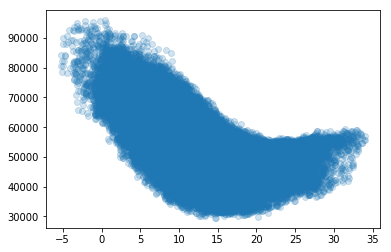

In [36]:
plt.scatter(Xinput['Th_prev'], Yconso['y'], alpha=0.2)
plt.show()

La consommation pourrait être modélisée par une fonction linéaire par morceaux de la température, avec une pente plus importante pour les températures froides que pour les températures élevées. Au lieu de fixer les gradients à 2400MW/°C et 0, ceux-ci pourraient être calibrés à partir des données.


### Entrainer un modèle
Notre modèle a des paramètres qu'il va falloir maintenant apprendre au vu de notre jeu d'entrainement. Il faut donc caler notre modèle sur ce jeu d'entrainement.

In [37]:
colsLR_simple = np.concatenate(([s for s in XinputTrain.columns.get_values() if 'temp_prev_with_' in s], colsToKeepHour, colsToKeepWeekday, colsToKeepMonth))

mTrain = linear_model.LinearRegression() #fit_intercept = False
mTrain.fit(XinputTrain[colsLR_simple], YconsoTrain[['y']])


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

### Interpréter le modèle 

In [38]:
coef_joli = pd.DataFrame(np.concatenate(( np.array([colsLR_simple]).T,mTrain.coef_.T),axis=1),columns = ['variable','coefficient']).sort_values(by="coefficient",
                                                                                                                                                ascending=False)
print(coef_joli)


                         variable          coefficient
33                        month_1   405233419340491.75
34                        month_2    405233419339111.8
44                       month_12    405233419336490.2
35                        month_3   405233419334973.75
43                       month_11    405233419334658.8
42                       month_10    405233419330642.7
36                        month_4    405233419330033.8
39                        month_7    405233419329382.0
38                        month_6   405233419329136.44
41                        month_9    405233419328875.4
37                        month_5   405233419327930.75
40                        month_8   405233419326062.44
0   temp_prev_with_threshold_heat   1415.8825139853177
32                      weekday_6   -84408750967673.81
31                      weekday_5   -84408750964953.73
26                      weekday_0   -84408750960833.94
30                      weekday_4   -84408750959891.11
27        

<font color='green'>

* Commentez les coefficients de régression obtenus. 
* Comparez notamment les gradients obtenus avec le modèle naïf.

</font>

### Faire des prédictions
Une fois qu'un modèle de prévision est entrainé, il ne s'avère utile que s'il est performant sur de nouvelles situations. Faisons une prévision sur notre jeu de test. Traçons les courbes obtenues et calculons les scores.

In [39]:
forecastTest = np.concatenate(mTrain.predict(XinputTest[colsLR_simple]))
forecastTrain = np.concatenate(mTrain.predict(XinputTrain[colsLR_simple]))

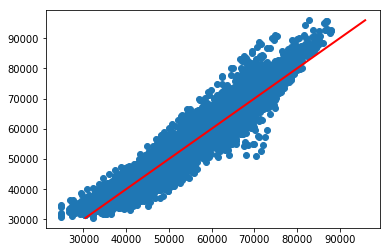

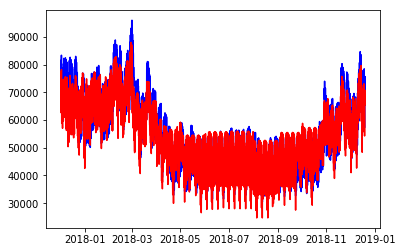

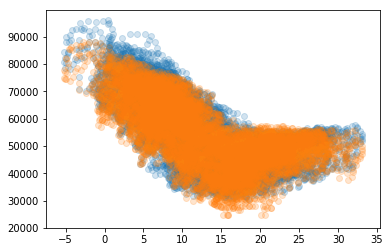

In [40]:
plt.scatter(forecastTest, YconsoTest[['y']])
plt.plot([YconsoTest[['y']].min(), YconsoTest[['y']].max()], [YconsoTest[['y']].min(), YconsoTest[['y']].max()], 'r', lw=2)
plt.show()

plt.plot(YconsoTest['ds'], YconsoTest['y'], 'b', YconsoTest['ds'], forecastTest, 'r')
plt.show()

plt.scatter(XinputTest['Th_prev'], YconsoTest['y'], alpha=0.2)
plt.scatter(XinputTest['Th_prev'], forecastTest, alpha = 0.2)
plt.show()

In [41]:
evaluation(YconsoTrain, YconsoTest, forecastTrain,  forecastTest)
evalWD,evalHour,evalJF = evaluation_par(XinputTest,YconsoTest,forecastTest,avecJF=True)
print(str(round(evalWD*100,1)))
print(str(round(evalHour*100,1)))
print(str(round(evalJF*100,1)))

l'erreur relative moyenne de test est de :5.0%
l'erreur relative max de test est de :37.9%
le rmse de test est de :3585.0

l'erreur relative moyenne de train est de :5.0%
l'erreur relative max de train est de :52.3%
le rmse de test est de :3268.0
         APE
        mean
weekday     
0        5.0
1        4.4
2        4.3
3        4.6
4        4.2
5        5.4
6        7.1
      APE
     mean
hour     
0     5.4
1     5.8
2     5.9
3     6.2
4     6.6
5     6.3
6     5.0
7     5.5
8     6.6
9     5.8
10    4.9
11    4.5
12    4.3
13    3.9
14    4.2
15    4.3
16    4.5
17    4.5
18    4.6
19    4.8
20    4.2
21    4.1
22    4.2
23    4.4
              APE
             mean
JoursFeries      
0             4.8
1            11.5


#### Comment se distribue l'erreur ?

In [44]:
erreur_relative_test, erreur_moyenne_test, erreur_max_test, rmse = modelError(YconsoTest, forecastTest)

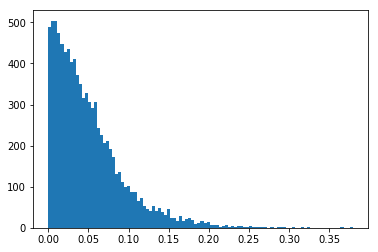

In [45]:
num_bins = 100
plt.hist(erreur_relative_test, num_bins)
plt.show()

#### A quel moment se trompe-t-on le plus ?

In [46]:
iplot([{"x": YconsoTest['ds'], "y": erreur_relative_test}])

In [47]:
erreur_relative_test.head()

0    0.008807
1    0.011939
2    0.017625
3    0.024508
4    0.029293
Name: y, dtype: float64

Regardons les erreurs les plus flagrantes.

In [86]:
q = 0.9975
threshold = np.quantile(erreur_relative_test.values, q)
print("quantile des erreurs à {}% : ".format(100*q),"%0.5f"%threshold)

quantile des erreurs à 99.75% :  0.24310


In [87]:
error_order = np.argsort(erreur_relative_test.values)[::-1]
mask = (erreur_relative_test.iloc[error_order] >= threshold)
erreurs_df = pd.DataFrame(np.concatenate((YconsoTest[['ds','y']],np.array([forecastTest]).T),axis=1),columns=["date","y","prev"])
display(erreurs_df.iloc[error_order][mask])


,date,y,prev
753,2018-01-01 09:00:00+00:00,51035,58210.9
754,2018-01-01 10:00:00+00:00,52495,60824.8
752,2018-01-01 08:00:00+00:00,51462,59169.3
755,2018-01-01 11:00:00+00:00,54658,62674.6
6176,2018-08-15 08:00:00+00:00,34450,39945.3
6177,2018-08-15 09:00:00+00:00,36950,38991.5
5932,2018-08-05 04:00:00+00:00,34873,34130.8
3848,2018-05-10 08:00:00+00:00,37729,42579.2
3847,2018-05-10 07:00:00+00:00,35657,42796.4
5933,2018-08-05 05:00:00+00:00,34187,32966.9


In [58]:
y_test_copy = YconsoTest[['ds','y']].copy()
y_test_copy["erreur_relative_%"] = erreur_relative_test.values * 100
y_test_copy['weekday'] = y_test_copy.ds.dt.weekday
y_test_copy['hour'] = y_test_copy.ds.dt.hour
y_test_copy['is_bank_holiday'] = XinputTest["JoursFeries"]

groupe_wd = y_test_copy.groupby(['weekday'], as_index=True)
stats_wd = groupe_wd["y", "erreur_relative_%"].aggregate(["mean"])

groupe_hour = y_test_copy.groupby(['hour'], as_index=True)
stats_hour = groupe_hour["y", "erreur_relative_%"].aggregate(["mean"])

groupe_bh = y_test_copy.groupby(['is_bank_holiday'], as_index=True)
stats_bh = groupe_bh["y", "erreur_relative_%"].aggregate(["mean"])

display(stats_wd)
display(stats_hour)
display(stats_bh)

,y,erreur_relative_%
,mean,mean
weekday,,
0,55912.076515,4.979209
1,57483.568182,4.444919
2,57836.390909,4.344826
3,57280.214506,4.643738
4,56973.284091,4.227285
5,51864.092424,5.371768
6,49412.735606,7.130836


,y,erreur_relative_%
,mean,mean
hour,,
0,56202.244792,5.382993
1,51416.981771,5.777492
2,50179.838542,5.940521
3,47925.721354,6.176459
4,46197.690104,6.569666
5,46190.002604,6.306783
6,48590.125000,5.004986
7,52820.690104,5.475637


,y,erreur_relative_%
,mean,mean
is_bank_holiday,,
0,55461.742181,4.829134
1,47947.261364,11.539209


Au vu des résultats précédents :
<font color= 'green'>

- que pensez-vous du modèle?
- comment se distribue l'erreur?
- quand se trompe-t-on le plus?
- quelles variables explicatives ajouter?

</font>

## Modèles avancés (boîtes noires)

### Modèle RandomForest

<img src="pictures/randomForestExplain.png" width=500 height=30>

#### Choix des données d'entrée

In [59]:
colsRF = np.concatenate((['lag1D','lag1W'],
                         colsToKeepWeather,colsToKeepMonth,colsToKeepWeekday,colsToKeepHour,colsToKeepHolidays))
list(colsRF)

['lag1D',
 'lag1W',
 'Th_prev',
 'Th_prev_J_1',
 'month_1',
 'month_2',
 'month_3',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',
 'month_9',
 'month_10',
 'month_11',
 'month_12',
 'weekday_0',
 'weekday_1',
 'weekday_2',
 'weekday_3',
 'weekday_4',
 'weekday_5',
 'weekday_6',
 'hour_0',
 'hour_1',
 'hour_2',
 'hour_3',
 'hour_4',
 'hour_5',
 'hour_6',
 'hour_7',
 'hour_8',
 'hour_9',
 'hour_10',
 'hour_11',
 'hour_12',
 'hour_13',
 'hour_14',
 'hour_15',
 'hour_16',
 'hour_17',
 'hour_18',
 'hour_19',
 'hour_20',
 'hour_21',
 'hour_22',
 'hour_23',
 'JF_11Novembre',
 'JF_1erMai',
 'JF_8Mai',
 'JF_Ascension',
 'JF_Assomption',
 'JF_FeteNationale',
 'JF_Noel',
 'JF_NouvelAn',
 'JF_Paques',
 'JF_Pentecote',
 'JF_Toussaint']

#### Entrainement du modèle

In [60]:
# La cellule peut prendre un peu de temps à exécuter
print(Xinput.head(20))
rfTrain = RandomForestRegressor(n_estimators=30, max_features=len(colsRF), n_jobs=3, oob_score = True, bootstrap = True)
rfTrain.fit(XinputTrain[colsRF], YconsoTrain['y'])

                          ds  posan  Th_real_24h_avant    Th_prev  lag1D  \
0  2014-01-08 00:00:00+00:00      8           9.846930   9.911160    NaN   
1  2014-01-08 01:00:00+00:00      8           9.848500   9.790830    NaN   
2  2014-01-08 02:00:00+00:00      8           9.681580   9.634990    NaN   
3  2014-01-08 03:00:00+00:00      8           9.487130   9.445360    NaN   
4  2014-01-08 04:00:00+00:00      8           9.490410   9.241585    NaN   
5  2014-01-08 05:00:00+00:00      8           9.346880   9.045105    NaN   
6  2014-01-08 06:00:00+00:00      8           9.284855   8.915265    NaN   
7  2014-01-08 07:00:00+00:00      8           9.377060   8.964100    NaN   
8  2014-01-08 08:00:00+00:00      8           9.543030   9.106500    NaN   
9  2014-01-08 09:00:00+00:00      8          10.109460   9.630050    NaN   
10 2014-01-08 10:00:00+00:00      8          11.010330  10.447800    NaN   
11 2014-01-08 11:00:00+00:00      8          12.087900  11.583100    NaN   
12 2014-01-0

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=58, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=3, oob_score=True, random_state=None,
           verbose=0, warm_start=False)

<font color='green'>

* Grâce à l'aide de la fonction, déterminer les paramètres de cette méthode

</font>

#### Prediction

In [61]:
forecastTest = rfTrain.predict(XinputTest[colsRF])
forecastTrain = rfTrain.predict(XinputTrain[colsRF])

#### Evaluation

l'erreur relative moyenne de test est de :2.6%
l'erreur relative max de test est de :33.2%
le rmse de test est de :2251.0

l'erreur relative moyenne de train est de :0.8%
l'erreur relative max de train est de :14.7%
le rmse de test est de :644.0


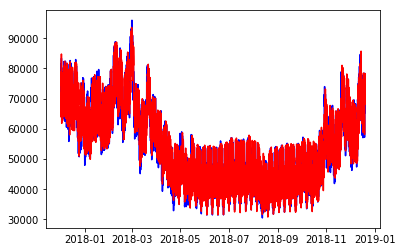

R^2 Training Score: 1.00 
OOB Score: 0.98 
R^2 Validation Score: 0.97


In [62]:
evaluation(YconsoTrain, YconsoTest, forecastTrain, forecastTest)

# on visualise nos previsions par rapport a la realité
plt.plot(YconsoTest['ds'], YconsoTest['y'], 'b', YconsoTest['ds'], forecastTest, 'r')
plt.show()

print('R^2 Training Score: {:.2f} \nOOB Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(rfTrain.score(XinputTrain[colsRF], YconsoTrain['y']), 
                                                                                             rfTrain.oob_score_,
rfTrain.score(XinputTest[colsRF], YconsoTest['y'])))

In [64]:
evalWD,evalHour,evalJF = evaluation_par(XinputTest,YconsoTest,forecastTest)
print(str(round(evalWD*100,1)))
print(str(round(evalHour*100,1)))
print(str(round(evalJF*100,1)))

         APE
        mean
weekday     
0        4.6
1        2.5
2        2.1
3        2.0
4        1.9
5        2.3
6        2.6
      APE
     mean
hour     
0     2.2
1     2.3
2     2.4
3     2.5
4     2.7
5     2.9
6     3.0
7     3.3
8     3.1
9     2.8
10    2.5
11    2.3
12    2.3
13    2.4
14    2.4
15    2.5
16    2.7
17    2.8
18    2.7
19    2.6
20    2.5
21    2.4
22    2.2
23    1.9
             APE
            mean
JoursFeries     
0            2.4
1            7.2


# Bonus: à vous de jouer

Bravo ! Vous avez déjà créé un premier modèle performant pour faire des prévisions sur une fenêtre glissante à horizon 24h !

Maintenant à vous de mettre votre expertise pour créer de nouveaux modèles. Par exemple avec le modèle XGboost. Si vous voulez en apprendre plus => direction la formation DATAS2 !

Vous pouvez continuer à explorer le problème selon plusieurs axes:
- choix de la méthode de modélisation
- apprendre votre modèle sur une période différente
- créer de nouvelles variables explicatives ? Quid de la météo et de la température? Des jours fériés ? Du feature engineering plus complexe...
- détecter des outliers dans les données

Mettez-vous en 3 groupes, explorez pendant 30 minutes, et restituez.